In [1]:
import torch
from Models import convolutional_models as cnns
from Connectivity import Agent_Networks
import numpy as np
import copy
import torch.cuda
import numpy as np
import pickle
import random

from Algs import Algorithms as alg
from dataset_partition import CIFAR10Partition

###Float32 operations for faster training on NVIDIA A100.
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
#torch.backends.cudnn.benchmark = True


In [2]:
#Single Device Configuration, Select the GPU ID
dev = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
print(dev)


cuda:6


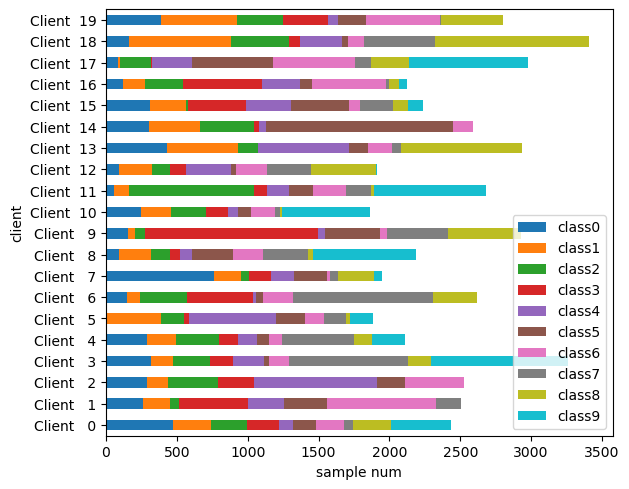

In [3]:
#Create the Dirichlet Non-IID Data Partitions by setting the suitable hyperparameter a and the number of clients 
num_clients = 20 #Number of Agents
Dirichlet_Alpha = 1 #Select the Dir(a) coeficient for the dataset partition
train_loader, testloader = CIFAR10Partition(num_clients=num_clients, da=Dirichlet_Alpha)

In [4]:
#Select the hyperparameters for training
lr = 0.1              #Initial Learning Rate
nesterov = False      #Nesterov Momentum
momentum = 0          #Local SGD Momentum
weight_decay = 0      #SGD Weight Decay


epochs = 500           #Number of Training Epochs
MC_iterations = 1      #Number of Monte Carlo Iterations
ga = 3                 #Gombertz Alpha
freq = 1               #Communication Frequency (in terms of local minibatch updates)
milestones = []        #Milestones for Learning Rate Decay

RP = True             #Set to true to perform Random Projections on the gradients before adaptive weighting
RP_proj_dim = 100      #Random Projection dimension
N = Agent_Networks.ring_graph(num_clients)   #Create the Communication Graph topology

In [ ]:
# Create the Initial Adjacency Matrix setting the weights as 1/length_of_neighborhood
A = torch.zeros(num_clients,num_clients)
W = torch.zeros(num_clients,num_clients).to(dev)

for i in range(num_clients):
    for j in N[i]:
        A[i,j] = (1/len(N[i]))

A.to(dev).float()
W.copy_(A)

print(A)

#Set the tensors that will store the results
agent_t_acc = torch.zeros(epochs,MC_iterations,num_clients)
agent_tl = torch.zeros(epochs,MC_iterations,num_clients)

avg_t_acc = torch.zeros(epochs,MC_iterations)
avg_tl = torch.zeros(epochs,MC_iterations)



for mc in range(MC_iterations):
    
    #1) DO INITIALIZATION BEFORE TRAINING
    #Initialize the models and optimizers for each client and their lr schedulers
    client_models, optimizers, lr_scheduler = cnns.define_CIFAR10_CNN(dev, num_clients, lr, momentum, weight_decay, nesterov,milestones)

    #Count model params
    num_params = alg.count_model_learnable_params(client_models[0])

    #Initialize the stheta matrix
    stheta = torch.zeros(num_clients,num_clients).to(dev)
    com_iter = 0
    
    Zi = alg.initialize_models_buffers(dev,client_models) #Initialize the Zi buffers for each client, they store the models of each client
    #and will be used during consensus step
    #Main training loop:

    if RP:
        R = torch.randn(RP_proj_dim, num_params).to(dev) #RANDOM PROJECTION MATRIX
    if not RP:
        RP_proj_dim = num_params #Use the original gradient dimension in case of not using random projection

    for r in range(epochs):
      
    
        for i,data in enumerate(zip(*train_loader)):

            #Perform the local client updates and store the gradients in the SG matrix
            SG = alg.DSGD_local_client_update(dev,num_clients, data, client_models,optimizers)

            if RP: #    Random projection step (optional)
                SG = R @ SG.T
                SG = SG.T

            if i % freq == 0:  #Do a communication step every 'freq' local updates
                #COMMENT THE FOLLOWING LINE TO RETRIEVE DSGD-CW:
                A,stheta = alg.adaptive_combination_weights(dev,SG,num_clients,RP_proj_dim,com_iter,N,stheta, gombertz_alpha=ga) #Update the combination weights based on the adaptive weighting method:
                #alg.adaptive_combination_weights(dev,SG,num_clients,com_iter,W,stheta, gombertz_alpha = ga) #Update the combination weights based on the adaptive weighting method:
                Zi = alg.update_models_state_dict_in_place(client_models, Zi)   #Get a snapshot of the client models in Zi buffers
                #Do consensus step:
                for ind in range(num_clients):
                    client_models[ind].load_state_dict(alg.neighborhood_aggregate_sd(Zi,N,ind,A))
                com_iter += 1
        
        test_loss, acc = alg.test(dev,num_clients,client_models, testloader)
        
        #At the end of every epoch measure the testing accuracy
    
        #Step the lr scedulers in case you use any lr scedule (optional):
        for c_id in range(num_clients): 
            lr_scheduler[c_id].step()
        
        #Store performance metrics (generalization error, testing accuracy) for visualizations
        avg_test_acc = torch.mean(acc)
        avg_t_acc[r,mc] = avg_test_acc.cpu()

        avg_t_loss = torch.mean(test_loss)
        avg_tl[r,mc] = avg_t_loss.cpu()
        agent_t_acc[r,mc,:] = acc.reshape(num_clients)
        agent_tl[r,mc,:] = test_loss.reshape(num_clients)

        #print(avg_test_acc)
        print( 'mc iteration: %0.3g epoch %0.3g | average test accuracy %0.3g | average test loss %0.3g ' % (mc,r, avg_test_acc.item(), avg_t_loss.item()))

        #if r % 100 == 0:
        torch.save(avg_t_acc, 'Results/Avg_Test_Accuracy_DSGD-AW-RP_CIFAR10_Dir_a1.pt')

  
           

tensor([[0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.3333],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3